In [207]:
import os
import tensorflow as tf
import sklearn as sk
from tensorflow import keras
from sklearn import manifold

In [189]:
import functools
import numpy as np
import pandas as pd
from scipy.special import expit

import sklearn as sk
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report

from tensorflow import keras
import tensorflow as tf

def split_companies_train_dev_test(companies):
    "Return train, dev, test set for companies"
    train, test = train_test_split(companies, test_size=0.1, stratify = companies.sector)
    train, dev = train_test_split(train, test_size=0.1, stratify = train.sector)
    return train, dev, test


def filter_stocks(stocks, tickers):
    return stocks.loc[tickers]


def df_to_ts(df):
    res = df.copy()
    res.index = pd.DatetimeIndex(pd.to_datetime(res.date))
    res.drop('date', axis=1)
    return res


def log_softmax(x):
    return x - np.log(np.sum(np.exp(x)))


def sigmoid(x):
    return expit(x)


def load_data(stock_filename=None, indices_filename=None):

    if stock_filename is None:
        stock_filename = '../../data/processed/wiki_stocks_returns.csv'

    if indices_filename is None:
        indices_filename = '../../data/processed/wiki_indices_returns.csv'

    stocks = pd.read_csv(stock_filename, index_col=False) # long format
    indices = pd.read_csv(indices_filename, index_col=False) # wide format

    # Implementation of hierarchical clustering
    drop_column = lambda df,i=0: df.drop(df.columns[i], axis=1)

    stocks = drop_column(stocks)
    stocks = stocks.drop('name', axis=1)
    stocks = stocks.dropna()

    companies = stocks.groupby('ticker').first().reset_index()
    sectors_counts = companies.sector.value_counts()
    sectors_proportions = sectors_counts/sectors_counts.sum()
    sectors_unique = sectors_counts.index.tolist()

    stocks = stocks.set_index('ticker')

    indices_ts = df_to_ts(indices[['date'] + sectors_unique])
    stocks_ts = df_to_ts(stocks.reset_index())

    stocks_all = pd.merge(stocks_ts, indices_ts, 'left')
    stocks_all = stocks_all.dropna() # loss of 200 000 observations
    stocks_all = stocks_all.drop('sector', axis=1)
    stocks_all = stocks_all.groupby('ticker').apply(df_to_ts)
    stocks_all = stocks_all.drop(['ticker', 'date'], axis=1)
    stocks_all = stocks_all.rename(columns={'close': 'pct_return'})

    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(sectors_counts.index.tolist())
    ticker_to_sector = dict(zip(companies.ticker, label_encoder.transform(companies.sector)))

    return stocks_all, companies, label_encoder, ticker_to_sector

def sectors_statistics(companies):
    sectors_counts = companies.sector.value_counts()
    sectors_proportions = sectors_counts/sectors_counts.sum()
    sectors_unique = sectors_counts.index.tolist()
    return sectors_counts, sectors_proportions, sectors_unique

def random_subset(df, window_size=21):
    if df.shape[0]-window_size < 0:
        return df
    idx = np.random.randint(0, df.shape[0]-window_size)
    ts = df[idx:idx+window_size]
    return ts

class StocksSequence(keras.utils.Sequence):

    def __init__(self, stocks_data,  companies_data, window_size, label_encoder,
                 batch_size, mode_key='train'):
        self.stocks_data = stocks_data
        self.batch_size = batch_size
        self.label_encoder = label_encoder
        self.companies_data = companies_data
        self.window_size = window_size
        self.mode_key = mode_key
        self.classes = []

        _, sectors_proportion, _ = sectors_statistics(companies_data)
        self.sectors_proportion = sectors_proportion

    def __len__(self):
        return int(np.ceil(self.stocks_data.shape[0] / float(self.batch_size)))

    def __getitem__(self, idx):

        idx = np.random.choice(self.companies_data.shape[0], self.batch_size)
        df = self.companies_data.iloc[idx]
        model_input_data = [random_subset(self.stocks_data.loc[t], self.window_size)
                            for t in df.ticker]
        model_input = np.array([df.values for df in model_input_data])

        if self.mode_key != 'infer':
            y_true = self.label_encoder.transform(df.sector)

        if self.mode_key == 'infer':
            if 'sector' in df.columns:
                self.classes.extend(self.label_encoder.transform(df.sector))

        if self.mode_key == 'infer':
            return model_input

        return model_input, y_true



In [188]:
model = keras.models.load_model('checkpoint/model_weights_seventeenth.json')


stocks_all, companies, label_encoder, ticker_to_sector = load_data(
    '../data/processed/wiki_stocks_returns.csv',
    '../data/processed/wiki_indices_returns.csv')

sectors_counts, sectors_proportions, sectors_unique = sectors_statistics(companies)
companies_data = {}
data_split = split_companies_train_dev_test(companies)
for i, k in enumerate(['train', 'dev', 'test']):
    companies_data[k] = data_split[i]
stocks_data = {k: filter_stocks(stocks_all, v.ticker) for k, v in companies_data.items()}

KeyboardInterrupt: 

In [30]:
sequence_generator_test = StocksSequence(
    stocks_data['test'], companies_data['test'], 63, label_encoder, 256, 'eval')
y = model.evaluate_generator(sequence_generator_test, 300)

sequence_generator_infer = StocksSequence(
    stocks_data['test'], companies_data['test'], 63, label_encoder, 256, 'infer')

prediction = model.predict_generator(sequence_generator_infer, 300)

In [31]:

y_pred = np.argmax(prediction, 1)
y_true = np.array(sequence_generator_infer.classes[:y_pred.shape[0]])


conf_mat = confusion_matrix(y_true, y_pred)

conf_df = pd.DataFrame(conf_mat, columns=label_encoder.classes_.tolist(), index=label_encoder.classes_.tolist())
conf_df.to_csv('confusion_matrix.csv')
conf_df_ratio = conf_df.apply(lambda x: 100*round(x/x.sum(), 4), 0)
conf_df_ratio.to_csv('confusion_matrix_ratio.csv')

In [32]:
conf_df

,Business Services,Chemicals,Communication Equipment,Communication Services,Consumer Packaged Goods,Drug Manufacturers,Entertainment,Financial Services,Industrial Products,Insurance,Manufacturing - Apparel & Furniture,Medical,Oil and Gas,REITs,Retail - Apparel & Specialty,Technology
Business Services,1224,91,54,53,126,7,90,330,241,29,12,295,78,26,76,389
Chemicals,83,78,27,14,161,1,19,264,992,89,751,152,249,97,18,67
Communication Equipment,15,34,1032,16,36,2,16,66,159,3,30,87,11,17,25,556
Communication Services,62,38,6,642,254,4,18,218,211,180,23,152,100,94,21,12
Consumer Packaged Goods,33,109,12,103,2228,32,81,165,225,72,63,393,226,77,145,145
Drug Manufacturers,36,17,1,29,172,963,33,74,95,60,3,505,32,29,45,39
Entertainment,99,144,32,199,133,1,1295,423,98,92,36,280,108,93,85,122
Financial Services,404,183,44,153,430,14,121,6625,495,401,94,604,284,237,186,239
Industrial Products,93,181,14,45,218,10,32,299,3369,56,122,275,214,154,87,109
Insurance,31,52,0,9,171,7,1,728,167,1608,10,74,109,195,8,23


In [33]:
conf_df_ratio

,Business Services,Chemicals,Communication Equipment,Communication Services,Consumer Packaged Goods,Drug Manufacturers,Entertainment,Financial Services,Industrial Products,Insurance,Manufacturing - Apparel & Furniture,Medical,Oil and Gas,REITs,Retail - Apparel & Specialty,Technology
Business Services,44.77,2.96,2.89,2.75,2.64,0.60,4.06,2.96,3.13,1.01,0.79,3.39,1.04,0.39,1.50,4.88
Chemicals,3.04,2.54,1.44,0.73,3.37,0.09,0.86,2.37,12.89,3.10,49.28,1.75,3.32,1.47,0.35,0.84
Communication Equipment,0.55,1.11,55.19,0.83,0.75,0.17,0.72,0.59,2.07,0.10,1.97,1.00,0.15,0.26,0.49,6.97
Communication Services,2.27,1.24,0.32,33.35,5.32,0.34,0.81,1.96,2.74,6.28,1.51,1.75,1.33,1.43,0.41,0.15
Consumer Packaged Goods,1.21,3.55,0.64,5.35,46.66,2.73,3.65,1.48,2.92,2.51,4.13,4.52,3.02,1.17,2.86,1.82
Drug Manufacturers,1.32,0.55,0.05,1.51,3.60,82.24,1.49,0.66,1.23,2.09,0.20,5.81,0.43,0.44,0.89,0.49
Entertainment,3.62,4.69,1.71,10.34,2.79,0.09,58.41,3.80,1.27,3.21,2.36,3.22,1.44,1.41,1.68,1.53
Financial Services,14.78,5.96,2.35,7.95,9.01,1.20,5.46,59.52,6.43,13.98,6.17,6.94,3.79,3.60,3.67,3.00
Industrial Products,3.40,5.89,0.75,2.34,4.57,0.85,1.44,2.69,43.79,1.95,8.01,3.16,2.86,2.34,1.72,1.37
Insurance,1.13,1.69,0.00,0.47,3.58,0.60,0.05,6.54,2.17,56.07,0.66,0.85,1.46,2.96,0.16,0.29


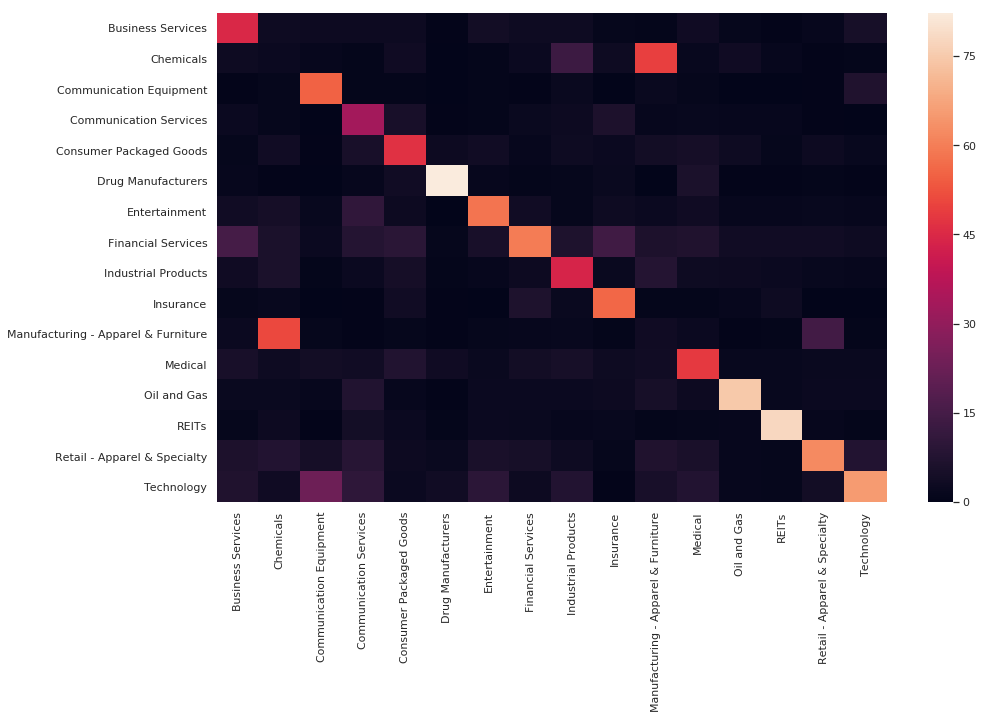

In [34]:
import seaborn as sns
import matplotlib.pylab as plt
sns.set()
plt.rcParams['figure.figsize'] = (15, 9)
sns.heatmap(conf_df_ratio)


In [35]:
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_.tolist()))

                                     precision    recall  f1-score   support

                  Business Services       0.45      0.39      0.42      3121
                          Chemicals       0.03      0.03      0.03      3062
            Communication Equipment       0.55      0.49      0.52      2105
             Communication Services       0.33      0.32      0.32      2035
            Consumer Packaged Goods       0.47      0.54      0.50      4109
                 Drug Manufacturers       0.82      0.45      0.58      2133
                      Entertainment       0.58      0.40      0.47      3240
                 Financial Services       0.60      0.63      0.61     10514
                Industrial Products       0.44      0.64      0.52      5278
                          Insurance       0.56      0.50      0.53      3193
Manufacturing - Apparel & Furniture       0.03      0.02      0.02      3184
                            Medical       0.48      0.65      0.55      648

In [24]:
model.save_weights('checkpoint/model_seventeenth_first.json')

In [190]:
class ClassPredictor:
    """
    Predicts the class of a stocks
    """
    def __init__(self, model, window_size, prediction_sample=10, mode_key='train'):
        self.model = model
        self.window_size = window_size
        self.mode_key = mode_key
        self.prediction_sample = prediction_sample

    def predict(self, stocks_data):
        model = self.model
        batch_df_data = [random_subset(stocks_data, self.window_size) for i in range(self.prediction_sample)]
        batch_data = np.array([df.values for df in batch_df_data])
        return model.predict_on_batch(batch_data)

    def predict_class(self, keras_output):
        return pd.DataFrame(np.argmax(np.array(keras_output), 2)).apply(
            lambda s: np.argmax(s.value_counts()), 1)

class_predictor = ClassPredictor(model, 63, 25, 'predict')
df = stocks_data['test']
companies = companies_data['test']

res = []
for t in companies.ticker:
    res.append(class_predictor.predict(df.loc[t]))

predictions = class_predictor.predict_class(res)


In [120]:
y_true = label_encoder.transform(companies.sector)
print(classification_report(y_true, predictions.values, target_names=label_encoder.classes_.tolist()))


                                     precision    recall  f1-score   support

                  Business Services       1.00      1.00      1.00         3
                          Chemicals       0.00      0.00      0.00         3
            Communication Equipment       0.67      1.00      0.80         2
             Communication Services       1.00      1.00      1.00         2
            Consumer Packaged Goods       1.00      0.75      0.86         4
                 Drug Manufacturers       1.00      0.50      0.67         2
                      Entertainment       1.00      1.00      1.00         3
                 Financial Services       1.00      1.00      1.00        10
                Industrial Products       0.71      1.00      0.83         5
                          Insurance       1.00      1.00      1.00         3
Manufacturing - Apparel & Furniture       0.00      0.00      0.00         3
                            Medical       0.75      1.00      0.86         

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [196]:
stocks_data_all = pd.concat( [stocks_data['train'], stocks_data['dev'],
                              stocks_data['test']], 0)

companies_data_all = pd.concat([companies_data['train'], companies_data['dev'],
                           companies_data['test']], 0)

In [197]:

model.summary()
layer = model.get_layer('Embedding')
model_embedding = keras.models.Model(model.input, layer.output)

sequence_generator_infer = StocksSequence(
    stocks_data_all, companies_data_all, 63, label_encoder, 256, 'infer')

model_embedding.predict_generator(sequence_generator_infer, 10)

embedding_predictor = ClassPredictor(model_embedding, 63, 25, 'predict')

res = [embedding_predictor.predict(stocks_data_all.loc[t]) for t in companies_data_all.ticker]

average_embedding = np.mean(np.array(res), axis=1)




__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series_input (InputLayer)       (None, 63, 17)       0                                            
__________________________________________________________________________________________________
gaussian_noise_21 (GaussianNois (None, 63, 17)       0           series_input[0][0]               
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 63, 17)       0           gaussian_noise_21[0][0]          
__________________________________________________________________________________________________
conv1d_35 (Conv1D)              (None, 63, 64)       1152        lambda_7[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [200]:
metadata_path = 'logs/embedding/metadata.tsv'
companies_data_all[['ticker', 'sector']].to_csv(metadata_path, sep='\t', index=False)

In [205]:
tf.reset_default_graph()
with tf.variable_scope('embedding', reuse=tf.AUTO_REUSE):
    embedding_variable = tf.get_variable('stock_embedding', initializer=tf.constant(np.array(average_embedding)))

In [206]:
projector = tf.contrib.tensorboard.plugins.projector

## Running TensorFlow Session
with tf.Session() as sess:
    saver = tf.train.Saver([embedding_variable])
    sess.run(embedding_variable.initializer)
    saver.save(sess, os.path.join('logs/embedding', 'embedding_variable.ckpt'))
    config = projector.ProjectorConfig()
    # One can add multiple embeddings.
    embedding = config.embeddings.add()
    embedding.tensor_name = embedding_variable.name
    # Link this tensor to its metadata(Labels) file
    embedding.metadata_path = './metadata.tsv'
    # Saves a config file that TensorBoard will read during startup.

    projector.visualize_embeddings(tf.summary.FileWriter('logs/embedding'), config)


In [232]:
tsne_points = manifold.TSNE(perplexity=50, learning_rate=10, n_iter=1000).fit_transform(average_embedding)

In [233]:
tsne_df = pd.DataFrame(tsne_points, columns=['x', 'y'])
tsne_df['sector'] = companies_data_all.sector.values

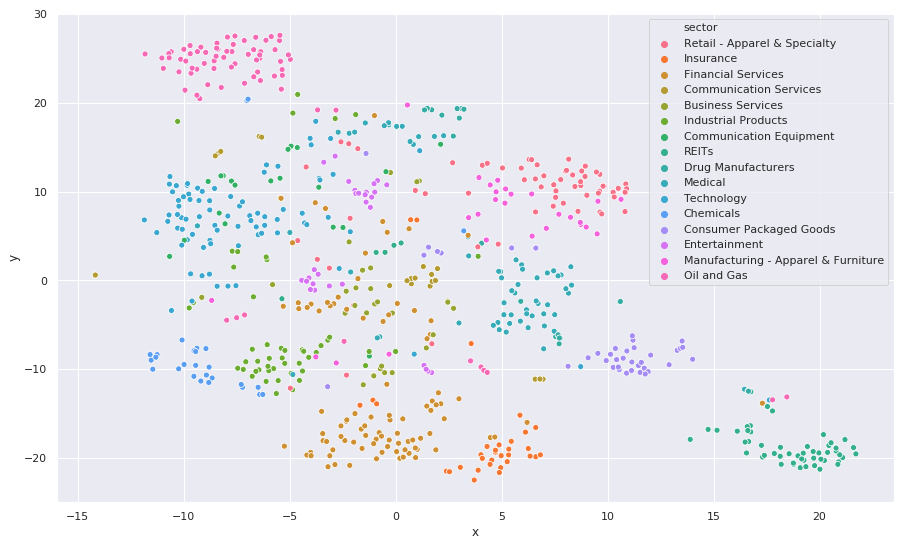

In [236]:
plt.rcParams['figure.figsize'] = (15, 9)
sns.scatterplot(x='x', y='y', hue='sector', data=tsne_df)
plt.show()

# Analysis

Usually the clusert a well separated. Financial services and REITs are well
separated and easily identified. The model seems to have difficulty to
differentiate somes chemical companies as their embedding seems to be close to
some industrial production companies.

In general, the more companies we had in the raw dataset the more precise the
groups are.

